# The PO algorithm, a python illustration

This notebook is an illustration of the Perturbation-Optimisation algorithm (PO). The PO algorithm simulates large non-centered non-stationary Gaussian samples when the precision $Q \in R^{N \times N}$ (inverse covariance) writes
\begin{equation}
Q = \sum_{k=1}^K H_k^t R_k^{-1} H_k
\end{equation}
often found in inverse problems (deconvolution, super-resolution, tomography, ...). For doing so, the algorithm supposes that

1. you can easily simulate centered gaussian law with covariance $R$ (when $R$ is diagonal for instance)
2. you can run a quadratic optimization algorithm (a conjugate gradient for instance) or a linear solver.

We suppose that the reader has sufficient knowledge of what is deconvolution, inverse problems or the problem of stochastic simulation of large and correlated Gaussian law. 

This notebook illustrates this algorithm on a deconvolution problem with python and the numpy/scipy stack only (and matplotlib for display). No extra dependencies are required. **We do not go into details and many aspects can be extended, detailed, optimized, etc. This is postponed to other work.**

For more details on linear solver, optimization algorithm and MCMC algorithm we refer the reader to

- *Iterative Methods for Sparse Linear Systems* by Yousef Saad (free)
- *Numerical Optimization* by Stephen J. Wright and J. Nocedal
- *Monte Carlo Statistical Methods* by Christian Robert, Christian and George Casella
- *Probabilistic Programming & Bayesian Methods for Hackers* by Cam Davidson-Pilon (free)

This notebook has been written by *F. Orieux*, assistant professor at University Paris-Saclay, associated with the Laboratory of Signal and System (L2S, Univ. Paris-Saclay - CNRS - CentraleSupélec), with help from Olivier Féron (EDF Lab) and Jean-François Giovannelli (IMS - Univ. Bordeaux). If you use any part of this work, please mention it. Static html and pdf version are available in the same [github](https://github.com/orieux/notebooks) repository.

## Publication

The PO algorithm has been published in

[1] François Orieux, Olivier Féron and Jean-François Giovannelli, **Sampling High-Dimensional Gaussian Distributions for General Linear Inverse Problems**, IEEE Signal Processing Letters, may, 2012. [[doi](https://doi.org/10.1109/LSP.2012.2189104)]
```
@Article{orieux2012,
    title = {Sampling high-dimensional Gaussian distributions
             for general linear inverse problems},
    author = {François Orieux and Olivier Féron and Jean-François Giovannelli},
    journaltitle = {IEEE Signal Processing Letters},
    year = {2012},
    date = {05-2012},
    number = {5},
    pages = {251--254},
    volume = {19},
    doi = {10.1109/LSP.2012.2189104},
    keywords = {Bayesian, high-dimensional sampling, inverse problem, 
                stochastic sampling, unsupervised}
}
```
It has been however published many times in the literature with different presentation, variation or extention. We can mention

- [2] Lalanne, P.; Prévost, D. & Chavel, P. - *Stochastic artificial retinas: algorithm, optoelectronic circuits, and implementation* - Applied Optics, 2001, 40
- [3] Tan, X.; Li, J. & Stoica, P. - *Efficient sparse Bayesian learning via Gibbs sampling* - ICASSP, IEEE, 2010.
- [4] Bardsley *et. al*, *Randomize-Then-Optimize : A Method for Sampling from Posterior Distributions in Nonlinear Inverse Problems*, 2017
- [5] Gilavert, C.; Moussaoui, S. & Idier, J. - *Efficient Gaussian Sampling for Solving Large-Scale Inverse Problems Using MCMC* - IEEE Transactions on Signal Processing, 2015.

Nevertheless, this notebook illustrates the PO algorithm as described in [1] but on deconvolution, a simpler to code problem, instead of super-resolution.

## Deconvolution

The deconvolution imaging problem suppose a blurred image $y \in R^M$ from which you want a deblurred version $\hat{x} \in R^N$. Images have not the same size and we will not suppose the periodic hypothesis. Fourier transform is therefor not permitted (this is not exactly true and another notebook will explain that more in detail). Then, the model is linear and not stationary (because of edge) and writes
$$y = Hx + n$$
where $H$ is a convolution matrix $\in R^{M\times N}$ and $n \in R^M$ an unknown noise. It is known that deconvolution is an ill-posed inverse problem, naive inversion like minimization of least-square provides an unstable solution, and noise is amplified with unusable results. A classical well-known solution is the introduction of additional information through model, also called prior information.

We suppose here

- a centered white Gaussian prior model for the noise $n$ of precision $\gamma_n I$ and
- a centered circulant Gaussian prior model for $x$ of precision $\gamma_xD^tD$, where $D$ is a convolution operator with laplacian impulsionnal response (second-order differences in line and column, or equivalently a high-pass filter).

This leads to the posterior law
$$p(x \mid y) \propto \exp \left( -\frac{\gamma_n}{2} \|y - Hx \|_2^2 \right) \exp \left( -\frac{\gamma_x}{2} \|Dx \|_2^2 \right).$$
This posterior law is a gaussian law with mean
$$ \mu = \Sigma H^t y$$
and covariance
$$\Sigma^{-1} = Q = \gamma_n H^tH + \gamma_x D^tD$$
that clearly fall under the condition of PO with $H_1 = H$, $R_1 = I$, $H_2 = D$ and $R_2 = I$.

The direct inversion of $Q$ is not feasible but the mean $\mu$ can be computed thanks to iterative algorithm like conjugate gradient that use $Q$ instead of $\Sigma$.

## Implementation

We use numpy to illustrate the algorithm with the following modules.

- `partial` simplify the definition of single argument function from multiple argument functions.
- `scipy.misc` is used to load the true image.
- `convolve2d` (abbreviated as conv2) is the convolution function with zero padding.
- `cg` is the conjugate gradient algorithm and `LinearOperator` a python object that mimic linear operator needed by `cg`.

In [1]:
from functools import partial

import numpy as np
import numpy.random as npr

# For 'ascent' image 
import scipy.misc  
# The non stationnary convolution operator
from scipy.signal import convolve2d as conv2

# The conjugate gradient solver
from scipy.sparse.linalg import cg, LinearOperator  

# For plotting
import matplotlib.pyplot as plt

We take the scipy `ascent` image as a true image with a square impulsionnal response.

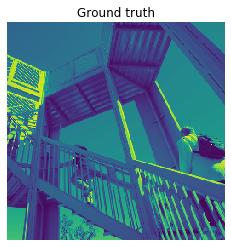

In [2]:
true = scipy.misc.ascent()[::2, ::2]  # Decimation to reduce size and time computation
blur_size = 5
ir = np.ones((blur_size, blur_size)) / blur_size**2

# The Laplacian IR
reg = np.array([[0, -1, 0], 
                [-1, 4, -1], 
                [0, -1, 0]], dtype=np.float32) 

im = plt.imshow(true)
plt.axis('off')
title = plt.title("Ground truth")

The noise precision is set to 10 ($\sigma \approx 0.3$).

In [3]:
true_gamma_n = 10

## Linear restoration

At this point the MAP estimator is
$$\hat{x}_{MAP} = \text{arg max}_{x} p(x \mid y) = \text{arg min}_{x} \|y - Hx \|_2^2 + \lambda \|Dx \|_2^2$$
with $\lambda = \gamma_x / \gamma_n$ that is the classical regularized least square linear estimator, which is also the mean of the gaussian law above
$$\hat{x}_{MAP} = \mu = (H^tH + \lambda D^t D)^{-1} H^t y.$$
Since the inversion of the matrix is not feasible, a the linear solver of the system $Qx = b$, with $Q = H^tH + \lambda D^t D$ and $b = H^t y$, is required. The solver needs a way to apply $Q$ and therefor $H$ and $D$, as well as their adjoint. 

In the case of convolution without periodic hypothesis, the operator corresponds to the `convolve2d` function (`conv2` in Matlab) with `valid` and `full` parameter.

True shape: (256, 256)
Data shape: (252, 252)
Transpose shape: (256, 256)


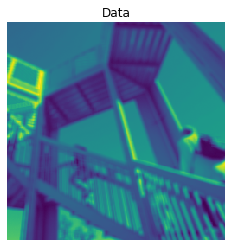

In [4]:
def forward(ir, image):
    """Apply H operator"""
    return conv2(image, ir, 'valid')


def backward(ir, image):
    """Apply H^t operator"""
    return conv2(image, np.fliplr(np.flipud(ir)), 'full')


def forward_backward(ir, image):
    """Apply H^tH operator"""
    return backward(ir, forward(ir, image))


# Abreviation
H = partial(forward, ir)
Ht = partial(backward, ir)
HtH = partial(forward_backward, ir)

# Simulate noisy data
data = H(true)
data = data + np.random.standard_normal(data.shape) / np.sqrt(true_gamma_n)

# Check size
print("True shape:", true.shape)
print("Data shape:", data.shape)
print("Transpose shape:", backward(data, ir).shape)

im = plt.imshow(data)
plt.axis('off')
title = plt.title('Data')

We must do the same thing for the regularization.

In [5]:
def reg_forward(reg, image):
    """Apply D operator"""
    return conv2(image, reg, 'valid')


def reg_backward(reg, image):
    """Apply D^t operator"""
    return conv2(image, np.fliplr(np.flipud(reg)), 'full')


def reg_forward_bacward(reg, image):
    """Apply D^tD operator"""
    return reg_backward(reg, reg_forward(reg, image))


# Abreviation
D = partial(reg_forward, reg)
Dt = partial(reg_backward, reg)
DtD = partial(reg_forward_bacward, reg)

The mean (that corresponds to the least square solution) can be computed with the conjugate gradient available in scipy. The API of this solver needs a `LinearOperator` python instance that applies the $Q$ operator. This API is not well suited for image since it must work on vectorized variables so we embed the code within unvectorization and vectorization operation. 

In [6]:
def hess(HtH, DtD, hyper, image):
    """Apply Q = H^tH + lambda * D^tD on image"""
    return HtH(image) + hyper * DtD(image)


def mv(HtH, DtD, hyper, shape, image):  
    """Apply Q on vectorized image"""
    # vector to image, apply Q = H^tH + lambda * D^tD, then vectorize
    return hess(HtH, DtD, hyper, image.reshape(shape)).reshape((-1, 1))


# The Q operator on vectorized unkown
# The matvec API is limited to function of one parameter so we use functools.partial
Q = LinearOperator(dtype=np.float32, 
                   shape=(true.size, true.size), 
                   matvec=partial(mv, HtH, DtD, 1e-10, true.shape))
# Vectorized $H^t y$
b = Ht(data).reshape((-1, 1))

The solver can be run now (with $b = H^ty$ as init).

In [7]:
sol, _ = cg(Q, b, x0=b)
sol = sol.reshape(true.shape)

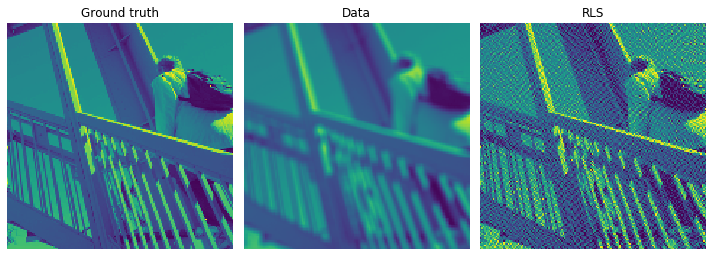

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10))
im = axes[0].imshow(true[100:300, 100:300], vmin=true.min(), vmax=true.max())
title = axes[0].set_title('Ground truth')
axes[0].axis('off')
im = axes[1].imshow(data[100:300, 100:300], vmin=true.min(), vmax=true.max())
title = axes[1].set_title('Data')
axes[1].axis('off')
im = axes[2].imshow(sol[100:300, 100:300], vmin=true.min(), vmax=true.max())
title = axes[2].set_title('RLS')
axes[2].axis('off')
plt.tight_layout()

Two questions arise. 

1. In the figure above, the deconvolution seems under regularized. We may want to estimate the hyperparameter value $\lambda$.
2. We have no uncertainty about the estimation.

The Bayesian approach and algorithms are a possibility (among others) to answer these questions.

## Bayesian restoration

With the Bayesian approach we can state the problem as inference on the extended posterior law
$$p(x, \gamma_n, \gamma_n \mid y) \propto \gamma_n^{\frac{M}{2} - 1} \gamma_x^{\frac{N-1}{2} - 1}\exp \left( -\frac{\gamma_n}{2} \|y - Hx \|_2^2 \right) \exp \left( -\frac{\gamma_x}{2} \|Dx \|_2^2 \right)$$
and to choose the posterior mean as estimator
$$\hat{x}, \hat{\gamma_n}, \hat{\gamma_x} = \int [x, \gamma_n, \gamma_x]\ p(x, \gamma_n, \gamma_x \mid y)\ d x\ d \gamma_n\ d \gamma_x.$$

One way to compute this integral is stochastic sampling with MCMC and more specifically the Gibbs sampler that leads to the following algorithm. 

## The Gibbs sampler algorithm

Initialize $k \gets 0$, $\gamma_n^{(0)}$ and $\gamma_x^{(0)}$ (for instance at $1$). Then
1. draw $x^{(k)} \sim p\left(x \mid \gamma_n^{(k)}, \gamma_x^{(k)}, y\right)$
2. draw $\gamma_n^{(k+1)} \sim p\left(\gamma_n \mid x^{(k)}, y\right)$
3. draw $\gamma_x^{(k+1)} \sim p\left(\gamma_x \mid x^{(k)}\right)$
4. $k \gets k + 1$ and return to step 1 except if stopping condition is reached.

Finally we estimate the posterior mean with the big number law from the last $P$ samples
$$\hat x = \frac{1}{P} \sum_{i=k-1-P}^{k-1} x^{(i)}.$$ 

With the above model, $p(\gamma_n \mid x, y)$ and $p(\gamma_x \mid x^{(k)})$ are Gamma law that can be easily simulated with numpy toolbox.

However, the conditional law $p(x \mid \gamma_n, \gamma_x, y)$ is a high dimensional Gaussian law with non-stationary correlation. Classical approaches like Cholesky factorization are unfeasible because of the size of the problem. However, the PO algorithm is 

## The PO sampler
 
The conditionnal law $p(x \mid \gamma_n, \gamma_x, y)$ is
$$p(x \mid \gamma_n, \gamma_x, y) \propto \exp \left( -\frac{\gamma_n}{2} \|y - Hx \|_2^2 \right) \exp \left( -\frac{\gamma_x}{2} \|Dx \|_2^2 \right).$$
This posterior law is a gaussian law with mean
$$ \mu = \gamma_n\Sigma H^t y$$
and covariance
$$\Sigma^{-1} = Q = \gamma_n H^tH + \gamma_x D^tD.$$

The PO sampler consiste, with the above model, of perturbation of the mean
1. $\tilde{y} \gets y + \epsilon_n$ with $\epsilon_n \sim \mathcal{N}\left(0, \gamma_n^{-1} I\right)$
2. $\tilde{x} \gets \epsilon_x$ with $\epsilon_x \sim \mathcal{N}\left(0, \gamma_x^{-1} I\right)$
and to solve the following optimization problem
$$x^{(k)} = \text{arg min}_x\ \frac{\gamma_n}{2} \|\tilde{y} - Hx \|_2^2 + \frac{\gamma_x}{2} \|D(x - \tilde{x})\|_2^2$$

In conclusion, in comparison to supervised deconvolution, the changes are just
1. simulate the hyperparameter according to the model (scalar Gamma law here with the standard toolbox)
2. simulate perturbation of the previous criterions and optimize it as before with a linear solver like conjugate gradient.

## Implementation

Almost everything is already in place except the $Q$ operator that must be slightly modified to take two hyperparameters.

In [9]:
def mv(HtH, DtD, gamma_n, gamma_x, image):  
    # vector to image
    image = image.reshape(true.shape)
    
    # Apply H^tH + mu * D^tD
    out = gamma_n * HtH(image) + gamma_x * DtD(image)
    
    # then vectorize
    return out.reshape((-1, 1))

We can now define our Gibbs sampler with `for` loops (I set the maximum number of iteration for the CG to 50 because it seems sufficient. The RJ-PO algorithm allows us to automatically tunes this value).

In [10]:
gamma_n, gamma_x = 1, 1
gamma_n_chain, gamma_x_chain = [gamma_n], [gamma_x]

burnin, max_iter, acc = 20, 100, 0

data_t = Ht(data)
mean = np.zeros(data_t.shape)
sample = np.zeros(data_t.shape)
cum2 = np.zeros(data_t.shape)
pshape = tuple(s - 2 for s in data_t.shape)  # depends on the regularization IR

for iteration in range(max_iter):
    # Perturbation
    data_tilde = data + npr.standard_normal(data.shape) / np.sqrt(gamma_n)
    x_tilde = npr.standard_normal(pshape) / np.sqrt(gamma_x)
    
    b = gamma_n * Ht(data_tilde) + gamma_x * Dt(x_tilde)   
    Q = LinearOperator(dtype=np.float32, shape=(true.size, true.size), 
                       matvec=partial(mv, HtH, DtD, gamma_n, gamma_x))
    
    # Optimization
    opt, _ = cg(Q, b.reshape((-1, 1)), x0=sample.reshape((-1, 1)), maxiter=50)
    sample = opt.reshape(true.shape)
    
    # Hyperparameter simulation
    gamma_n = npr.gamma(data.size / 2, 2 / np.sum(abs(data - H(sample))**2))
    gamma_x = npr.gamma((true.size - 1) / 2, 2 / np.sum(abs(D(sample))**2))
    
    # Keep in memory all the values
    gamma_n_chain.append(gamma_n)
    gamma_x_chain.append(gamma_x)
    
    # Keep in memory the full set of image sample can take a lot of space
    # We accumulate instead the samples to compute the mean and variance instead
    if iteration >= burnin:
        mean = mean + sample
        cum2 = cum2 + sample**2
        acc += 1
    
mean = mean / acc
std = np.sqrt(cum2 / acc - mean**2)

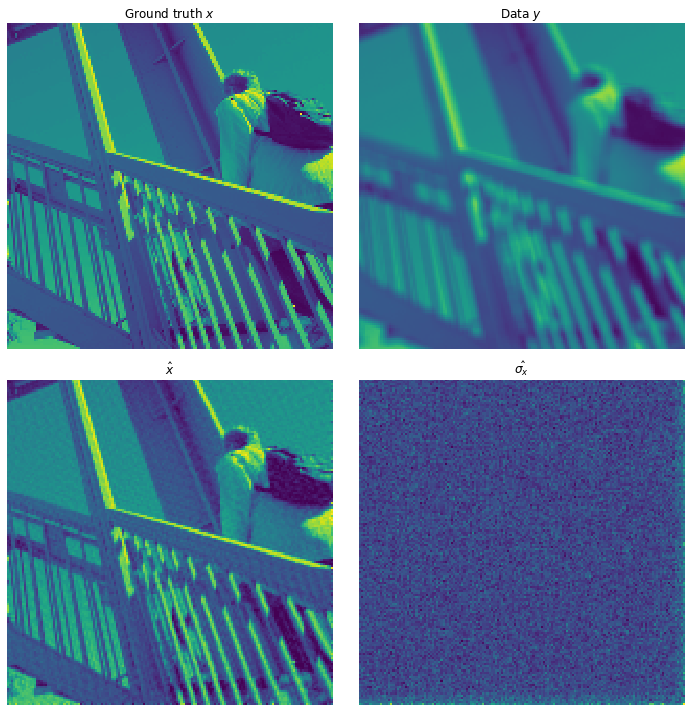

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0][0].imshow(true[100:300, 100:300], vmin=true.min(), vmax=true.max())
axes[0][0].set_title('Ground truth $x$')
axes[0][0].axis('off')

axes[0][1].imshow(data[100:300, 100:300], vmin=true.min(), vmax=true.max())
axes[0][1].set_title('Data $y$')
axes[0][1].axis('off')

axes[1][0].imshow(mean[100:300, 100:300], vmin=true.min(), vmax=true.max())
axes[1][0].set_title('$\hat{x}$')
axes[1][0].axis('off')

im = axes[1][1].imshow(std[100:300, 100:300])
axes[1][1].set_title('$\hat{\sigma_x}$')
axes[1][1].axis('off')

plt.tight_layout()

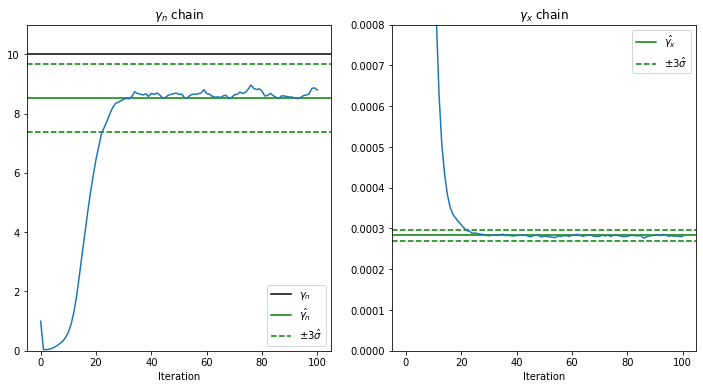

In [12]:
gn_mean = np.mean(gamma_n_chain[burnin:])
gn_std = np.std(gamma_n_chain[burnin:])
gx_mean = np.mean(gamma_x_chain[burnin:])
gx_std = np.std(gamma_x_chain[burnin:])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].axhline(true_gamma_n, color='k', label='$\gamma_n$')
axes[0].axhline(gn_mean, color='g', label='$\hat{\gamma_n}$')
axes[0].axhline(gn_mean + 3 * gn_std, color='g', ls='dashed')
axes[0].axhline(gn_mean - 3 * gn_std, color='g', ls='dashed', 
                label='$\pm 3 \hat\sigma$')
axes[0].plot(gamma_n_chain)
axes[0].set_ylim([0, 11])
axes[0].set_title('$\gamma_n$ chain')
axes[0].set_xlabel('Iteration')
axes[0].legend()

axes[1].axhline(gx_mean, color='g', label='$\hat{\gamma_x}$')
axes[1].axhline(gx_mean + 3 * gx_std, color='g', ls='dashed')
axes[1].axhline(gx_mean - 3 * gx_std, color='g', ls='dashed', 
                label='$\pm 3 \hat\sigma$')
axes[1].plot(gamma_x_chain)
axes[1].set_ylim([0, 0.0008])
axes[1].set_title('$\gamma_x$ chain')
axes[1].legend()
xlabel = axes[1].set_xlabel('Iteration')

## Conclusion

We show in this notebook that the PO algorithm allows the simulation of large gaussian law if a linear solver (or quadratic optimization algorithm) is available, which is a common case. This possibility allows the use of a Bayesian algorithm that can, for instance, estimate the hyperparameter or the uncertainty. We demonstrate on a deconvolution problem that the method is effective, does not require many extra steps, and is easily extendable to other problems. Other illustration can be found in mentionned references.